In [1]:
import torchaudio
import torch
import numpy as np
from IPython.display import Audio

In [2]:
from ASRAdversarialAttacks.AdversarialAttacks import ASRAttacks

In [3]:
# Loading the model from torchaudio model hub
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model()

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [4]:
# Checking the device available during the current environment (CUDA is recommended!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [6]:
# Loading the audio
#input_audio, sample_rate = torchaudio.load('/content/CRDNN_Model/AudioSamplesASR/spk1_snt1.wav')

In [5]:
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

In [20]:
input_audio, sample_rate = torchaudio.load(SPEECH_FILE)
input_audio = input_audio.to(device)

if sample_rate != bundle.sample_rate:
    input_audio = torchaudio.functional.resample(input_audio, sample_rate, bundle.sample_rate)
print(sample_rate, bundle.sample_rate)

16000 16000


In [7]:
import IPython
IPython.display.Audio(SPEECH_FILE)

In [8]:
with torch.inference_mode():
    emission, _ = model(input_audio)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


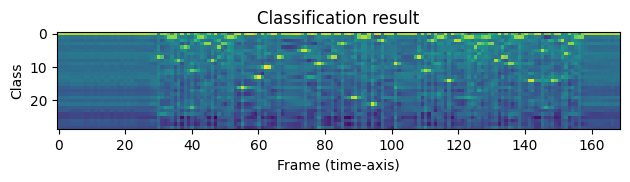

In [9]:

plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [10]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [11]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [12]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


In [13]:
# My target
target_transcription = 'I KEPT THAT CALMNESS WITH ME THROUGHOUT THE TIME'
true_transcription = 'I HAD THAT CURIOSITY BESIDE ME AT THIS MOMENT'
# Initializing attacker module
attack = ASRAttacks(model, device, bundle.get_labels())
target = list(target_transcription.upper().replace(" ", "|"))

In [22]:
#FGSM ATTACK
fgsm_audio = attack.FGSM_ATTACK(input_audio, target, epsilon = 0.01, targeted = True)

#FGSM PRINT
print(attack.INFER(torch.from_numpy(fgsm_audio)).replace("|"," "))
print(target_transcription)

I HAD THAT CURIOSITY BESIDE ME AT THIS MOMENT 
I KEPT THAT CALMNESS WITH ME THROUGHOUT THE TIME


In [23]:
print("Targeted WER is: ", attack.wer_compute([target_transcription], [fgsm_audio], targeted= True)[0])

Targeted WER is:  0.33333333333333337


In [24]:
info = attack.wer_compute([target_transcription], [fgsm_audio], targeted= True)[1]
print(f"Insertion: {info[0][1]}, Substitution: {info[0][0]}, Deletion: {info[0][2]}")

Insertion: 0, Substitution: 6, Deletion: 0


In [25]:
#BIM ATTACK
bim_audio = attack.BIM_ATTACK(input_audio, target, epsilon = 0.0015, alpha = 0.00009,
                   num_iter = 3000, targeted = True, early_stop = True)

#BIM PRINT
print('\n',attack.INFER(torch.from_numpy(bim_audio)).replace("|"," "))
print(target_transcription)

  0%|          | 0/3000 [00:00<?, ?it/s]

Breaking for loop because targeted Attack is performed successfully !

 I KEPT THAT CALMNESS WITH ME THROUGHOUT THE TIME
I KEPT THAT CALMNESS WITH ME THROUGHOUT THE TIME


In [26]:
print("Targeted WER is: ", attack.wer_compute([target_transcription], [bim_audio], targeted= True)[0])
info = attack.wer_compute([target_transcription], [bim_audio], targeted= True)[1]
print(f"Insertion: {info[0][1]}, Substitution: {info[0][0]}, Deletion: {info[0][2]}")

Targeted WER is:  1.0
Insertion: 0, Substitution: 0, Deletion: 0


In [27]:
IPython.display.Audio(bim_audio, rate=sample_rate)